In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

/home/beams/TOMO/conda/anaconda/envs/tomocupy/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in x,y
nz = 384  # object size in z    
ntheta = 1  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = 1 # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n # [cm] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 128 # [cm]
sx0 = 0.037 # [cm] motor offset from the focal spot
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
# magnifications = magnifications*0+1
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
beta = dxchange.read_tiff(f'data/beta-chip-{n}.tiff')[:]
delta = dxchange.read_tiff(f'data/delta-chip-{n}.tiff')[:]
u = delta+1j*beta
np.min(u.real)/np.max(u.imag)

-67.97931

## Smooth border to avoid aliasing effects in data modeling (maybe not needed)

In [4]:
# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v=np.exp(-20*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
# u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v)))
# u = u.astype('complex64')
# print(np.min(u.real))

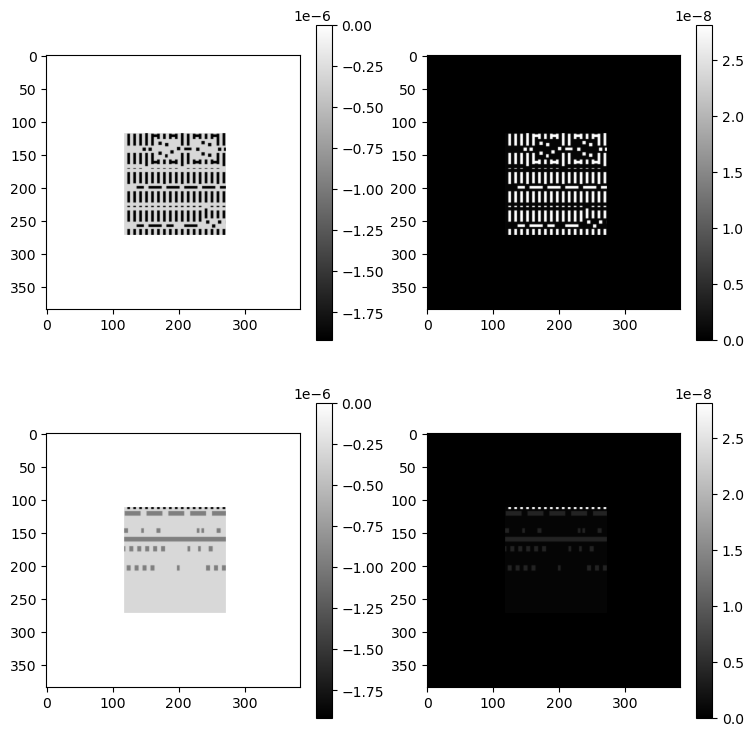

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[49+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[49+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography

In [6]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [7]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [8]:
Ru = tslv.fwd_tomo_batch(u)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [9]:
psi = pslv.exptomo(Ru)
# Ru0=pslv.logtomo(psi)
# print(np.linalg.norm(Ru-Ru0))

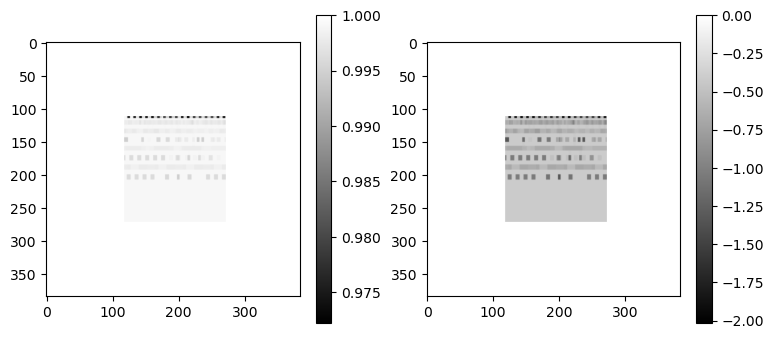

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
fig.colorbar(im)

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [11]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')
prb = prb_abs*np.exp(1j*prb_phase)  
prb[:] = 1

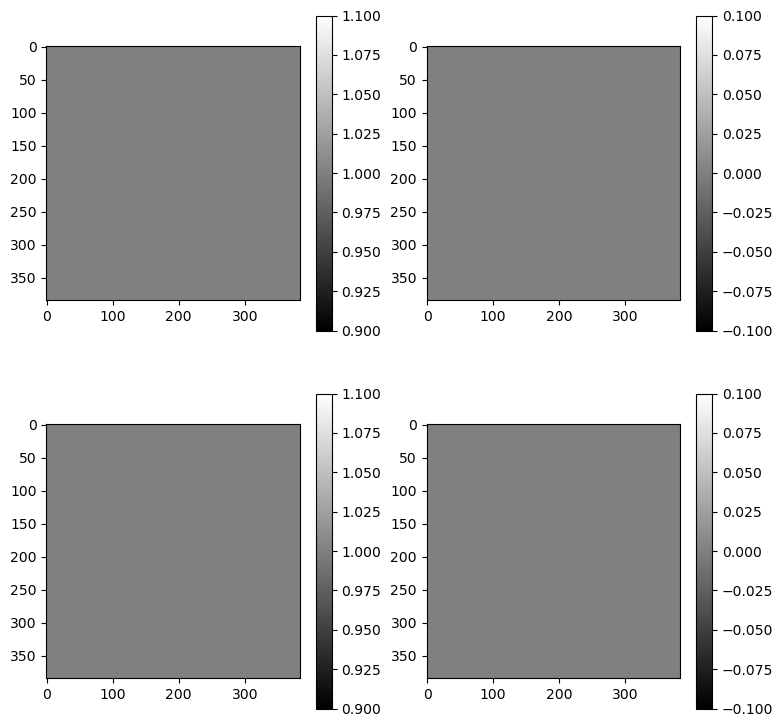

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)

# Compute holographic projections for all angles and all distances

In [13]:
fpsi = pslv.fwd_holo_batch(psi,prb)
fflat = pslv.fwd_holo_batch(psi*0+1,prb)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1)

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [14]:
data = np.abs(fpsi)**2
flat = np.abs(fflat)**2
data0 = np.abs(fpsi0)**2

# !!!Note that simple flat-field correction creates artifacts!!! Demonstration:

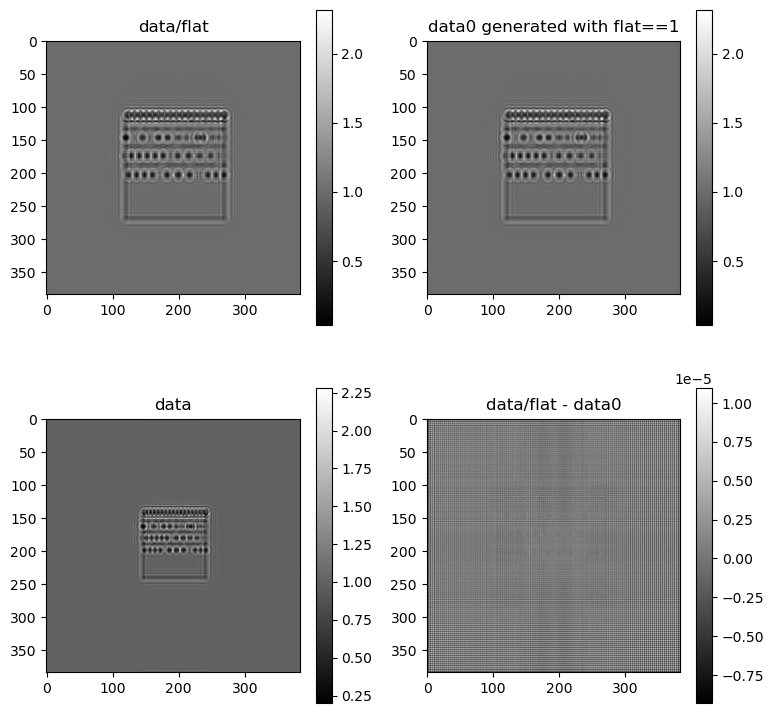

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0]/flat[0,0],cmap='gray')
axs[0,0].set_title('data/flat')
fig.colorbar(im)
im=axs[0,1].imshow(data0[0,0],cmap='gray')
axs[0,1].set_title('data0 generated with flat==1')
fig.colorbar(im)
im=axs[1,0].imshow(data[0,0],cmap='gray')
axs[1,0].set_title('data')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,0]/flat[0,0]-data0[0,0],cmap='gray')
axs[1,1].set_title('data/flat - data0')
fig.colorbar(im)

In [16]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_chip_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(flat[k,0],f'data/modeling/flat_chip_{n}_{k}',overwrite=True)

In [17]:
fpsi = pslv.fwd_holo_batch(psi,prb)
ppsi = pslv.adj_holo_batch(fpsi,prb)
print(np.sum(fpsi*np.conj(fpsi)))
print(np.sum(psi*np.conj(ppsi)))

(589637.1-1.0047413e-06j)
(589637.25+0.0026111566j)
